### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/CNN-Auteencoders/"

Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Extra Material


### Install missing libraries

In [2]:
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 9.3 MB/s eta 0:00:00


### Import libraries

In [3]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [4]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [10]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

In [7]:
# import tensorflow as tf
# import numpy as np
# import os
# import random
# import pandas as pd
# import seaborn as sns
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# from sklearn.metrics import confusion_matrix
# from PIL import Image
# from sklearn.manifold import TSNE

# tfk = tf.keras
# tfkl = tf.keras.layers
# print(tf.__version__)

In [8]:
# # Random seed for reproducibility
# seed = 42

# random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# tf.compat.v1.set_random_seed(seed)

In [9]:
# import warnings
# import logging

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=Warning)
# tf.get_logger().setLevel('INFO')
# tf.autograph.set_verbosity(0)

# tf.get_logger().setLevel(logging.ERROR)
# tf.get_logger().setLevel('ERROR')
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [20]:
(X_train, y_train), (X_test, y_test) = tfk.datasets.mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=len(X_test), stratify=y_train)

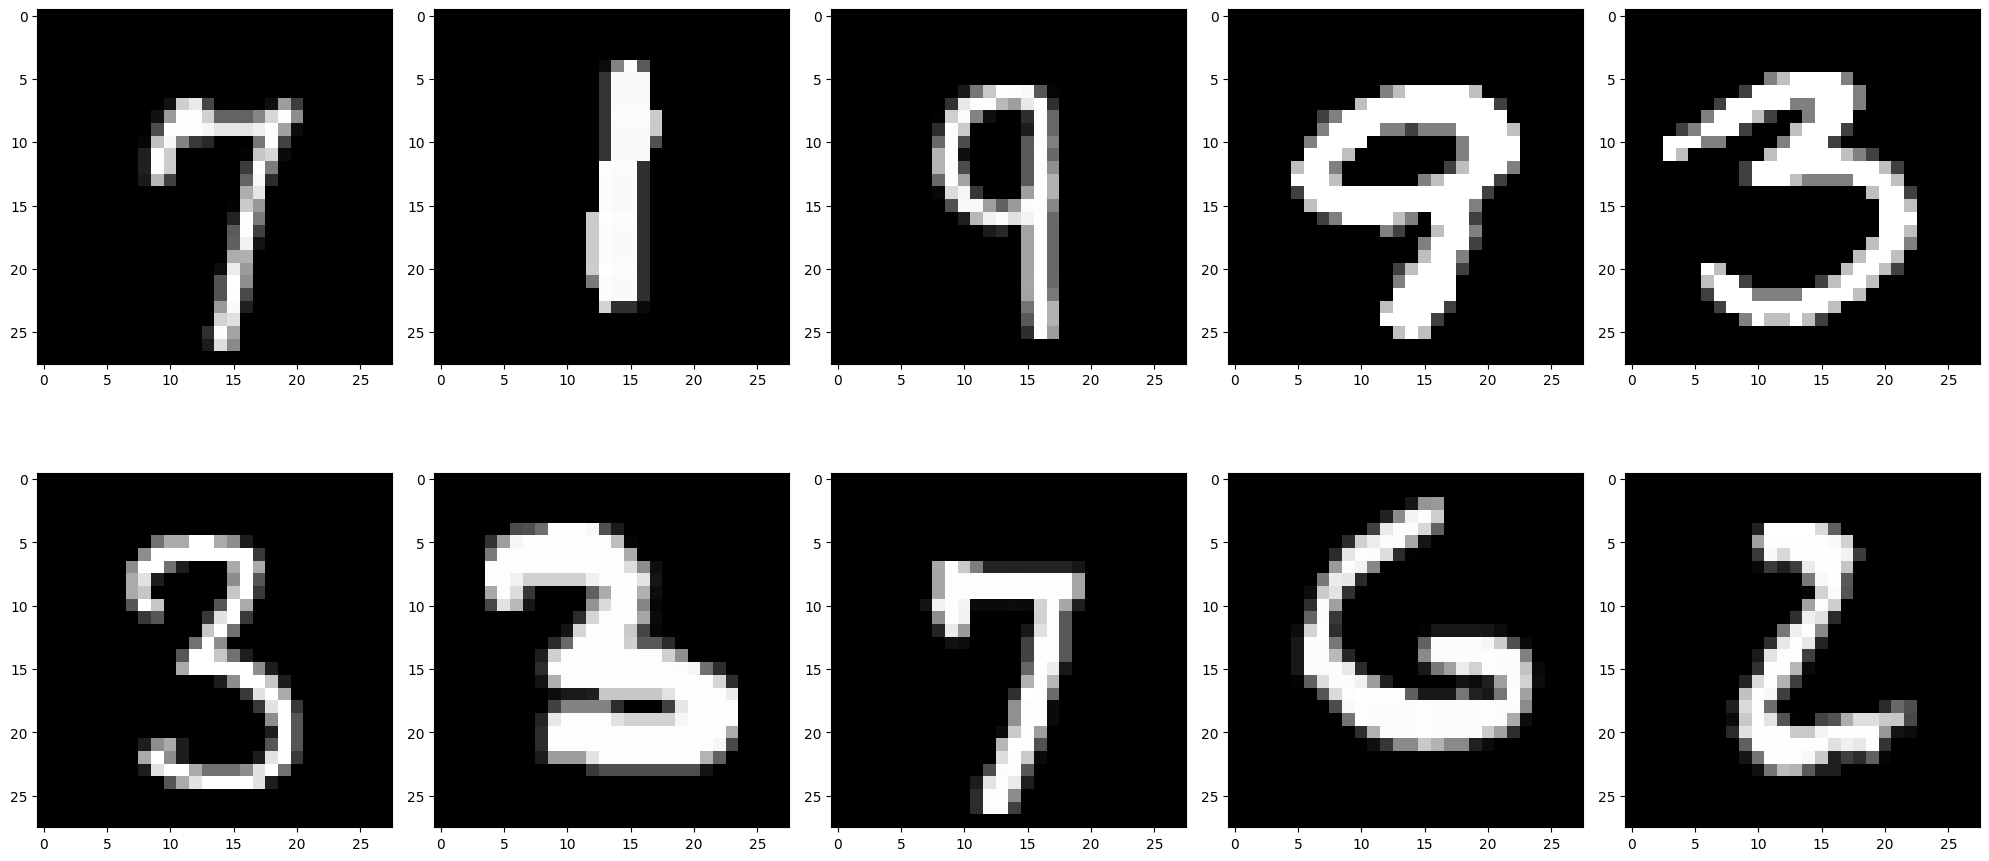

In [21]:
# Inspect the data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.squeeze(X_train[i]), cmap='gray')
plt.tight_layout()
plt.show()

In [22]:
X_train = ((np.expand_dims(X_train, axis=-1)-127.5)/127.5).astype(np.float32)
print('Data shape', X_train.shape)
print('Data min {:0.2f}\nData max {:0.2f}\nData mean {:0.2f}\nData std {:0.2f}'.format(
    X_train.min(), X_train.max(), X_train.mean(), X_train.std()))

Data shape (50000, 28, 28, 1)
Data min -1.00
Data max 1.00
Data mean -0.74
Data std 0.62


In [23]:
X_val = ((np.expand_dims(X_val, axis=-1)-127.5)/127.5).astype(np.float32)
print('Data shape', X_val.shape)
print('Data min {:0.2f}\nData max {:0.2f}\nData mean {:0.2f}\nData std {:0.2f}'.format(
    X_val.min(), X_val.max(), X_val.mean(), X_val.std()))

Data shape (10000, 28, 28, 1)
Data min -1.00
Data max 1.00
Data mean -0.74
Data std 0.61


In [24]:
X_test = ((np.expand_dims(X_test, axis=-1)-127.5)/127.5).astype(np.float32)
print('Data shape', X_test.shape)
print('Data min {:0.2f}\nData max {:0.2f}\nData mean {:0.2f}\nData std {:0.2f}'.format(
    X_test.min(), X_test.max(), X_test.mean(), X_test.std()))

Data shape (10000, 28, 28, 1)
Data min -1.00
Data max 1.00
Data mean -0.73
Data std 0.62


In [25]:
input_shape = X_train.shape[1:]
input_shape

(28, 28, 1)

In [26]:
latent_dim = 32

### Autoencoder

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 32, 32, 1)         0         
 ing2D)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        576       
                                                                 
 batch_normalization_3 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 64)        0   

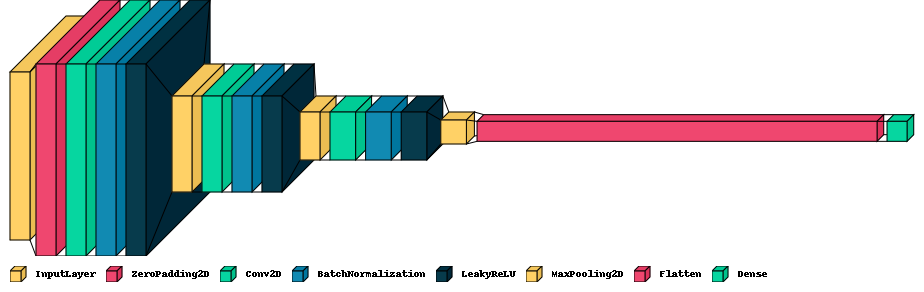

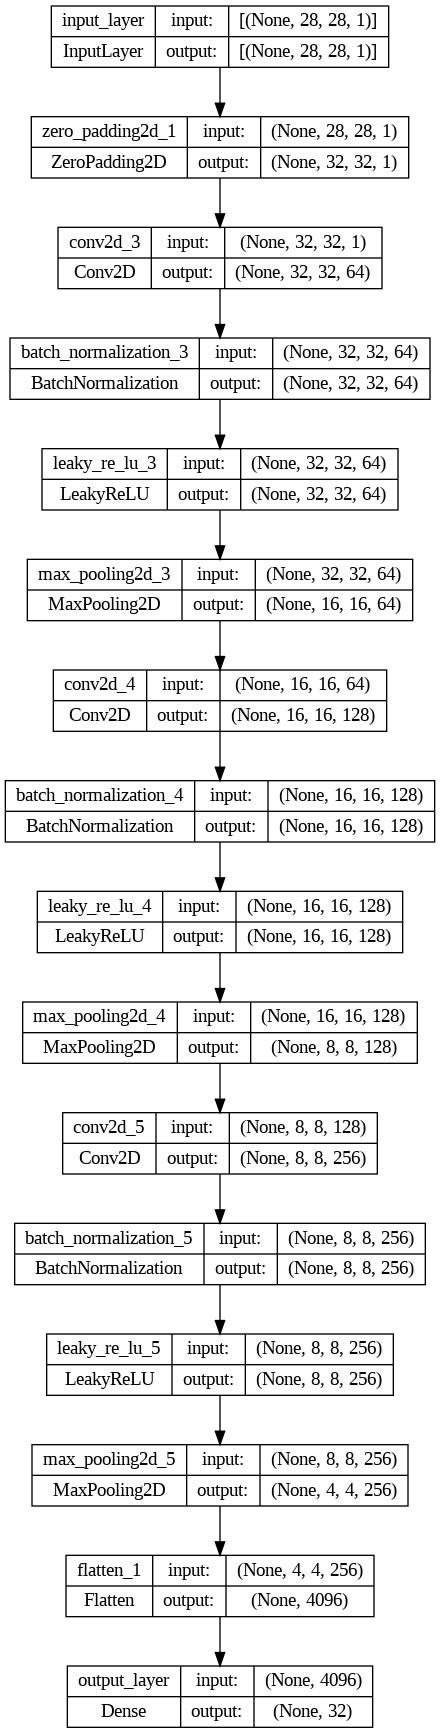

In [27]:
def get_encoder(enc_input_shape=input_shape, enc_output_shape=latent_dim, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=enc_input_shape, name='input_layer')
    x = tfkl.ZeroPadding2D((2,2))(input_layer)

    x = tfkl.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.MaxPooling2D()(x)

    x = tfkl.Conv2D(128, 3, padding='same', use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.MaxPooling2D()(x)

    x = tfkl.Conv2D(256, 3, padding='same', use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.MaxPooling2D()(x)

    x = tfkl.Flatten()(x)
    output_layer = tfkl.Dense(enc_output_shape, name='output_layer', use_bias=False)(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='encoder')

    # Return the discriminator
    return model
encoder = get_encoder(input_shape)
encoder.summary()
display(visualkeras.layered_view(encoder, legend=True, scale_xy=6))
tfk.utils.plot_model(encoder, show_shapes=True, expand_nested=True, to_file='encoder.png')

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 4096)              131072    
                                                                 
 batch_normalization_6 (Bat  (None, 4096)              16384     
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         294912    
 anspose)                                                  

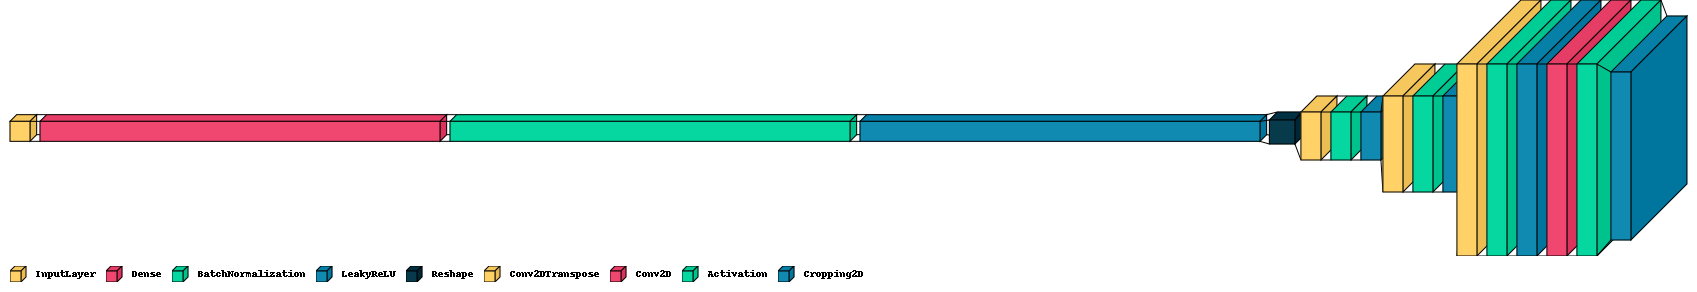

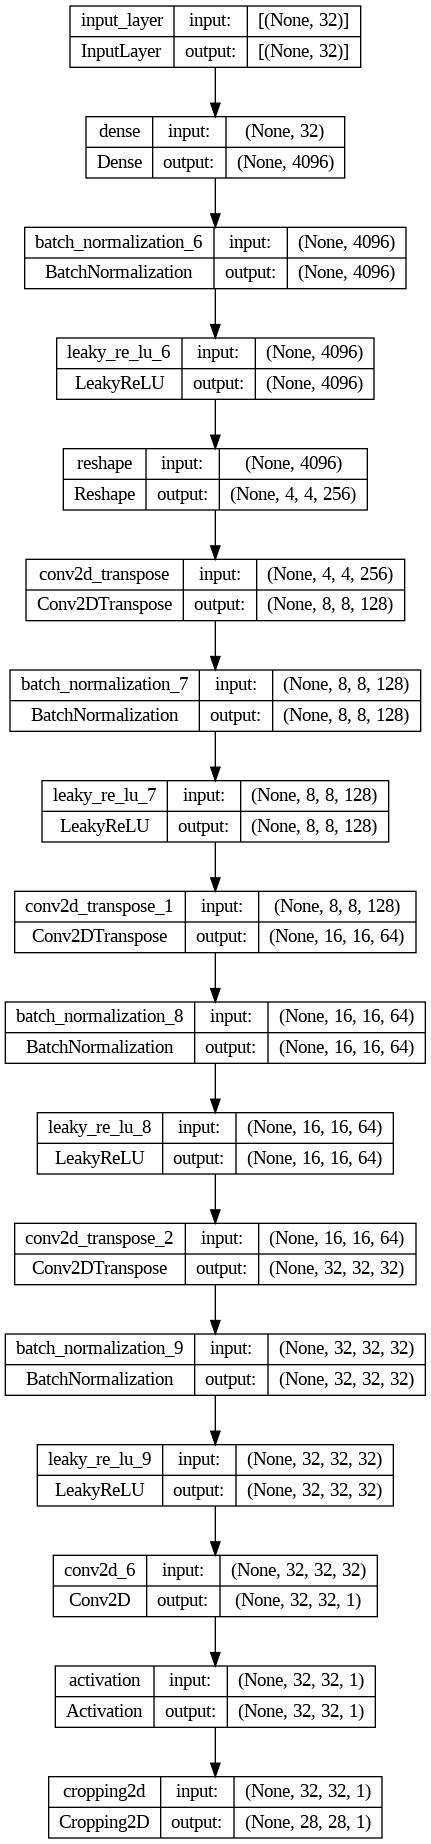

In [28]:
def get_decoder(dec_input_shape=latent_dim, dec_output_shape=input_shape, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=dec_input_shape, name='input_layer')
    x = tfkl.Dense(4*4*256, use_bias=False)(input_layer)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.Reshape((4,4,256))(x)

    x = tfkl.Conv2DTranspose(128, 3, padding='same', strides=2, use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    x = tfkl.Conv2DTranspose(64, 3, padding='same', strides=2, use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    x = tfkl.Conv2DTranspose(32, 3, padding='same', strides=2, use_bias=False)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    x = tfkl.Conv2D(dec_output_shape[-1], 3, padding='same', use_bias=False)(x)
    x = tfkl.Activation('tanh')(x)
    output_layer = tfkl.Cropping2D((2,2))(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='decoder')

    # Return the discriminator
    return model
decoder = get_decoder()
decoder.summary()
display(visualkeras.layered_view(decoder, legend=True, scale_xy=6))
tfk.utils.plot_model(decoder, show_shapes=True, expand_nested=True, to_file='decoder.png')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 32)                502080    
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         535712    
                                                                 
Total params: 1037792 (3.96 MB)
Trainable params: 1028256 (3.92 MB)
Non-trainable params: 9536 (37.25 KB)
_________________________________________________________________


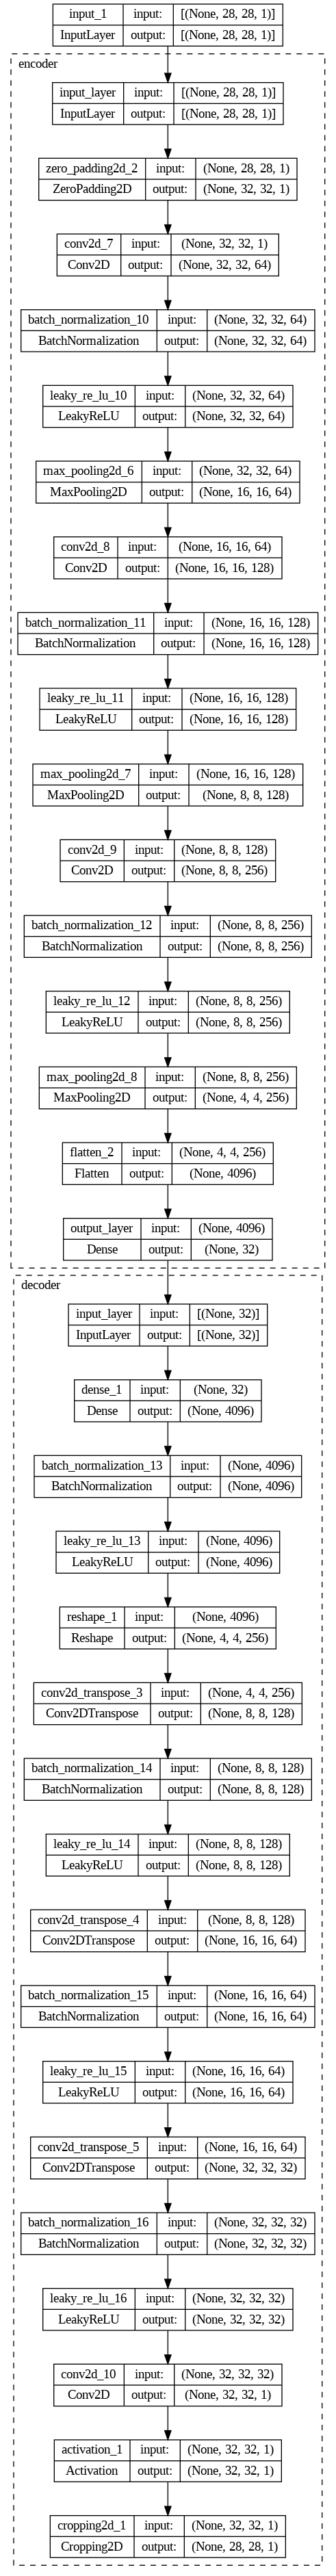

In [29]:
def get_autoencoder(ae_input_shape=input_shape, ae_output_shape=input_shape):
    tf.random.set_seed(seed)

    encoder = get_encoder()
    decoder = get_decoder()

    input_layer = tfkl.Input(shape=ae_input_shape)
    z = encoder(input_layer)
    output_layer = decoder(z)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='autoencoder')
    return model
autoencoder = get_autoencoder()
autoencoder.summary()
tfk.utils.plot_model(autoencoder, show_shapes=True, expand_nested=True, to_file='autoencoder.png')

In [34]:
learning_rate = 1e-3
optimizer = tf.optimizers.Adam(learning_rate)
autoencoder.compile(optimizer=optimizer, loss=tfk.losses.mean_squared_error)

batch_size = 128
epochs = 1000

In [35]:
history = autoencoder.fit(
    X_train,
    X_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val,X_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.1, min_lr=1e-5),
    ]
).history

Epoch 1/1000
391/391 [==============================] - 15s 25ms/step - loss: 0.0218 - val_loss: 0.0206 - lr: 0.0010
Epoch 2/1000
391/391 [==============================] - 9s 24ms/step - loss: 0.0199 - val_loss: 0.0202 - lr: 0.0010
Epoch 3/1000
391/391 [==============================] - 9s 24ms/step - loss: 0.0189 - val_loss: 0.0218 - lr: 0.0010
Epoch 4/1000
391/391 [==============================] - 10s 25ms/step - loss: 0.0179 - val_loss: 0.0182 - lr: 0.0010
Epoch 5/1000
391/391 [==============================] - 10s 25ms/step - loss: 0.0176 - val_loss: 0.0157 - lr: 0.0010
Epoch 6/1000
391/391 [==============================] - 10s 25ms/step - loss: 0.0170 - val_loss: 0.0160 - lr: 0.0010
Epoch 7/1000
391/391 [==============================] - 10s 26ms/step - loss: 0.0165 - val_loss: 0.0176 - lr: 0.0010
Epoch 8/1000
391/391 [==============================] - 10s 27ms/step - loss: 0.0164 - val_loss: 0.0174 - lr: 0.0010
Epoch 9/1000
391/391 [==============================] - 10s 25ms/s

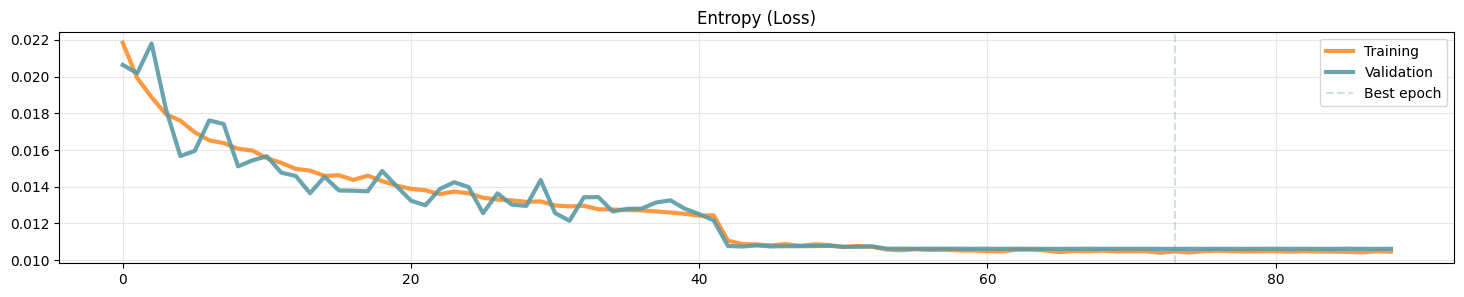

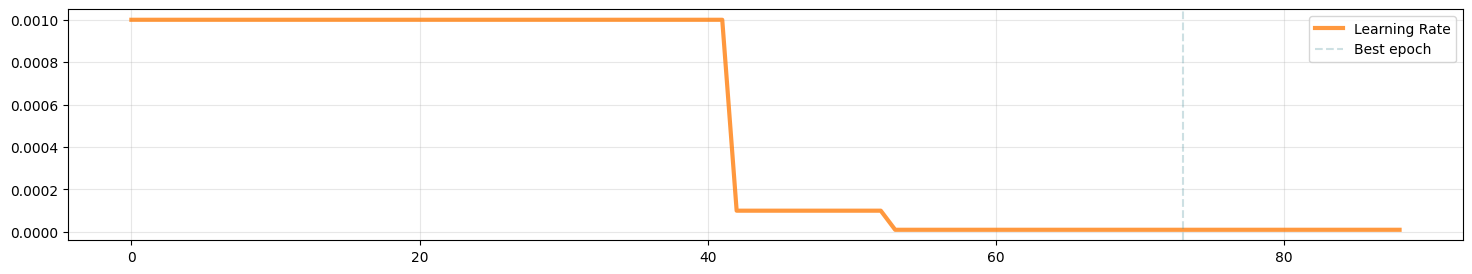

In [36]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Entropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [37]:
autoencoder.save('autoencoder')

In [38]:
autoencoder = tfk.models.load_model('autoencoder')
encoder = autoencoder.get_layer('encoder')
decoder = autoencoder.get_layer('decoder')

In [41]:
def get_reconstructions(model, X, imgs=10, verbose=True):
    predictions = model.predict(X, verbose=0)
    fig, axs = plt.subplots(2, imgs, figsize=(imgs*2, 4))
    for i in range(imgs):
        axs[0, i].imshow(np.squeeze(X[i]), cmap=plt.get_cmap('gray'))
        axs.flat[i].axis('off')
        axs[1, i].imshow(np.squeeze(predictions[i]), cmap=plt.get_cmap('gray'))
        axs.flat[i+imgs].axis('off')
    axs[0,imgs//2].set_title('Real data')
    axs[1,imgs//2].set_title('Reconstructions')
    plt.show()
    if verbose:
        mse_score = np.mean(tfk.losses.mean_squared_error(X, predictions))
        mae_score = np.mean(tfk.losses.mean_absolute_error(X, predictions))
        print('MSE:',mse_score)
        print('MAE:',mae_score)

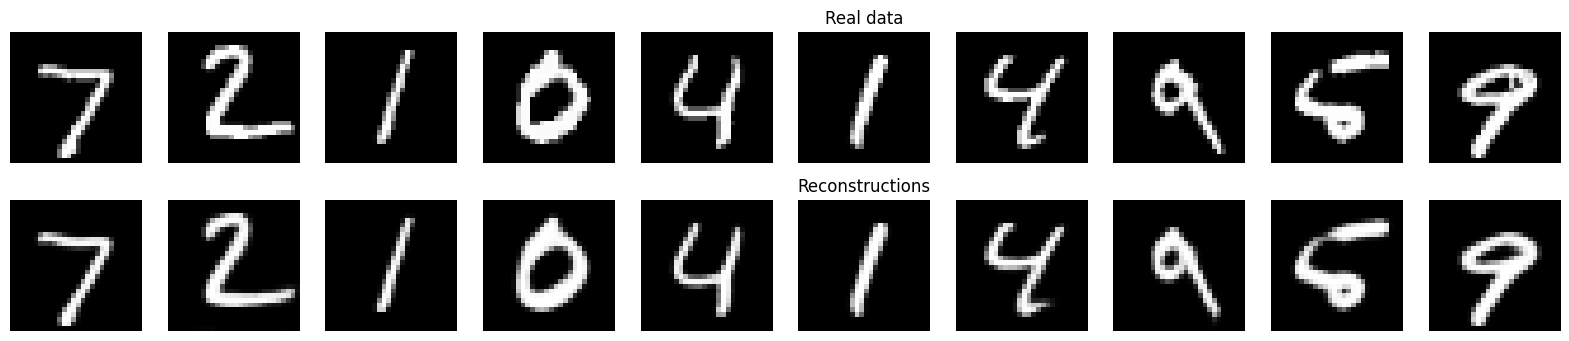

MSE: 0.010561161
MAE: 0.031524576


In [42]:
get_reconstructions(autoencoder, X_test)

#### Project the training set into the latent space

In [45]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict(data, verbose=0)
    if z_mean.shape[-1] != 2:
        z_mean = TSNE(n_components=2).fit_transform(z_mean)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

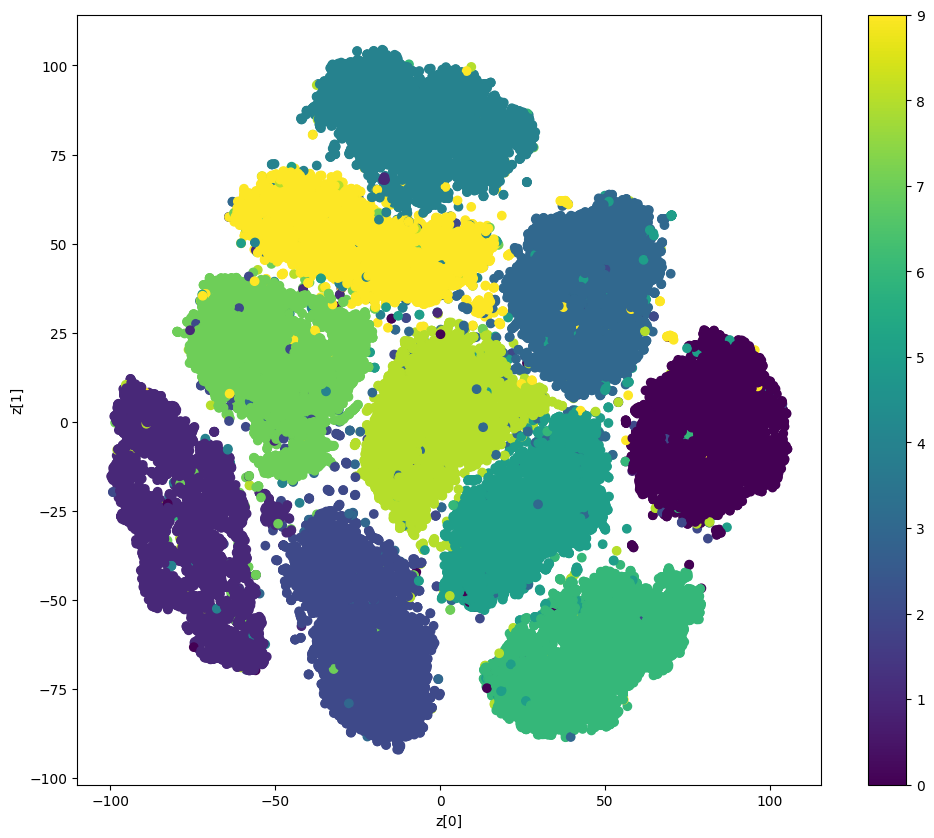

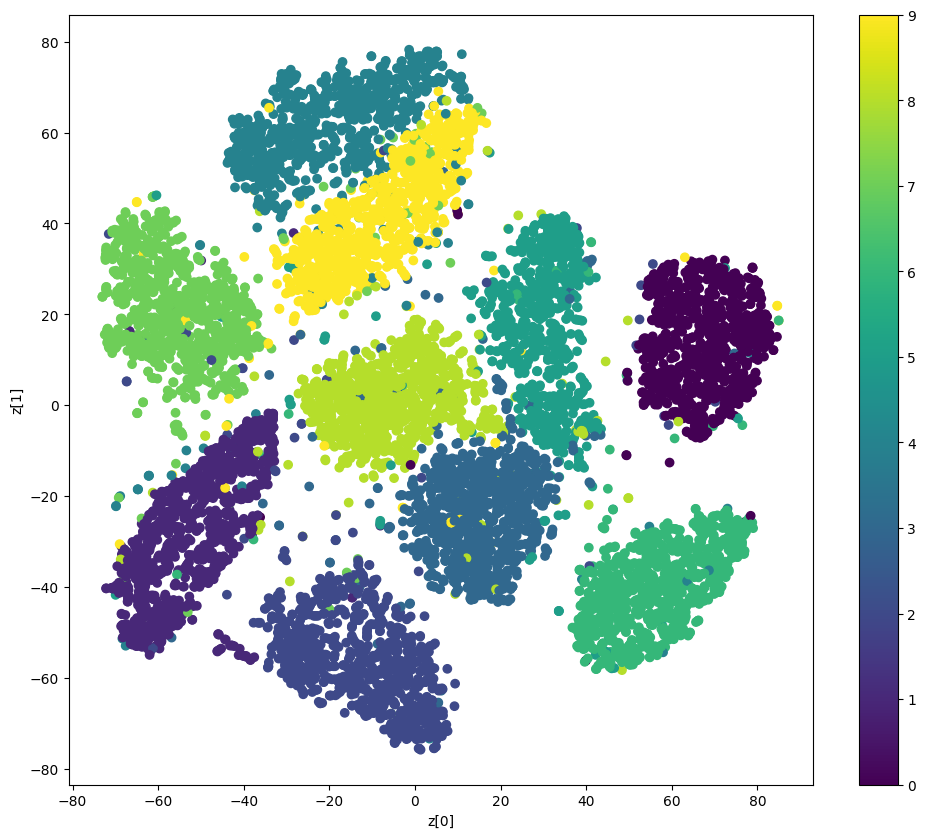

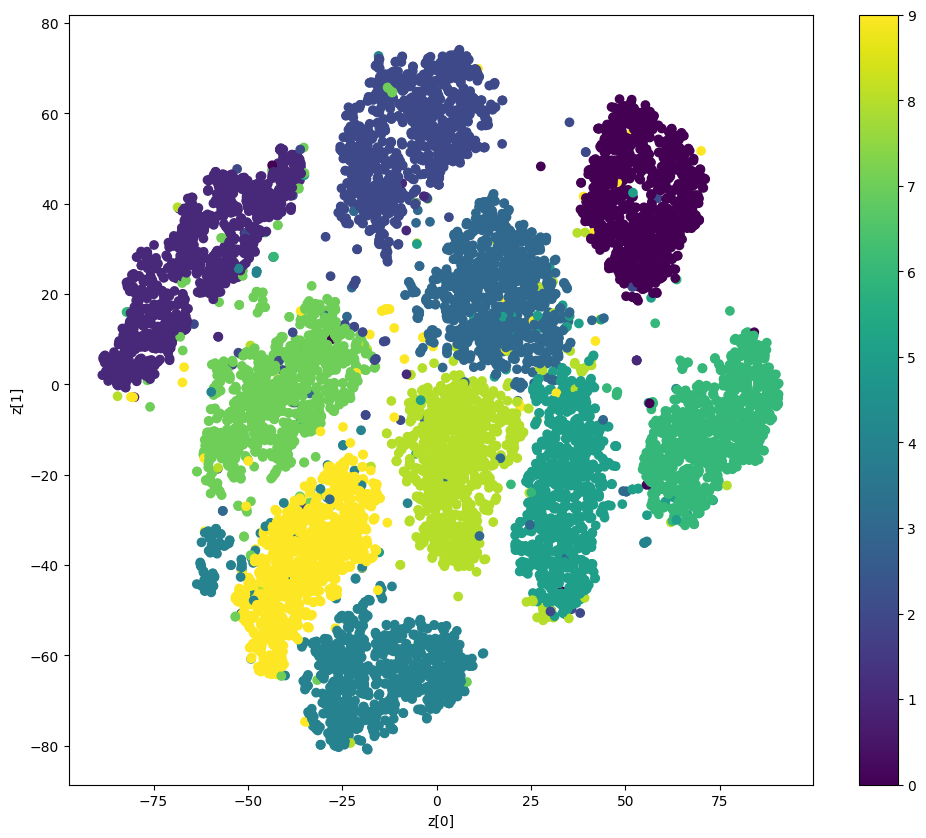

In [46]:
plot_label_clusters(encoder, X_train, y_train)
plot_label_clusters(encoder, X_val, y_val)
plot_label_clusters(encoder, X_test, y_test)